Best Parameters: {'rf__max_depth': 20, 'rf__n_estimators': 150}
Best F1 Score (CV Avg): 0.8331

Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.92      0.72      0.81      3738
         1.0       0.84      0.93      0.89      9432
         2.0       0.85      0.81      0.83      4251

    accuracy                           0.86     17421
   macro avg       0.87      0.82      0.84     17421
weighted avg       0.86      0.86      0.86     17421



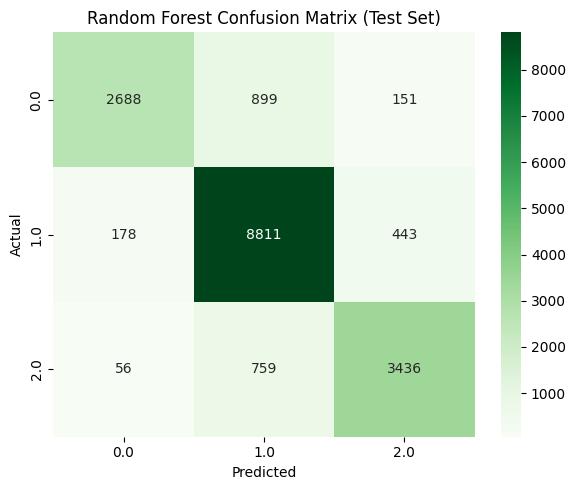

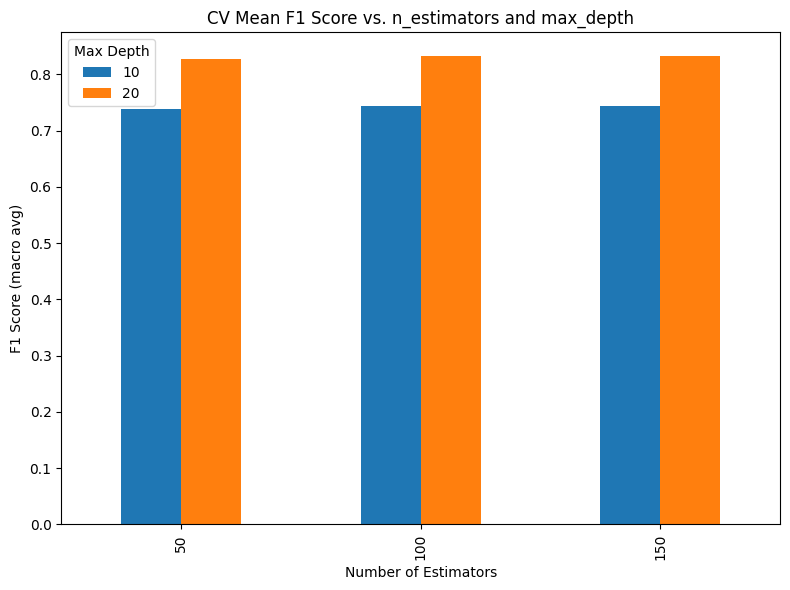

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# === Load and prepare data ===
df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Define pipeline ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # scaling within CV folds
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# === Hyperparameter grid ===
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 10, 20]
}

# # === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

# === Fit model ===
grid_search.fit(X_train, y_train)

# === Best parameters and scores ===
print("Best Parameters:", grid_search.best_params_)
print(f"Best F1 Score (CV Avg): {grid_search.best_score_:.4f}")

# === Evaluate on the hold-out test set ===
y_pred = grid_search.predict(X_test)
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))

# === Confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Plot cross-validation results ===
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_rf__n_estimators',
    columns='param_rf__max_depth'
)

pivot_table.plot(kind='bar', figsize=(8, 6))
plt.title("CV Mean F1 Score vs. n_estimators and max_depth")
plt.ylabel("F1 Score (macro avg)")
plt.xlabel("Number of Estimators")
plt.legend(title="Max Depth")
plt.tight_layout()
plt.show()


In [3]:
print(df_sensor.corr()['playYears'].sort_values(ascending=False))


playYears    1.000000
az_rms       0.249869
gy_mean      0.163157
gy_var       0.138090
ay_rms       0.123734
g_skewn      0.108979
a_min        0.100219
a_mean       0.091791
gy_rms       0.082482
ax_mean      0.075685
az_var       0.069764
a_skewn      0.057837
ax_var       0.055244
ay_var       0.048419
a_fft        0.039476
g_kurt       0.036372
g_fft        0.026702
gz_var       0.026333
gx_mean      0.025920
a_max        0.025518
g_max        0.011264
newv2        0.005855
newv3        0.002482
a_psdx       0.002462
newv4        0.000145
g_psdx      -0.002667
newv1       -0.006564
a_kurt      -0.032734
gz_rms      -0.035318
gz_mean     -0.047223
g_min       -0.066790
g_mean      -0.070042
gx_var      -0.088840
ax_rms      -0.090439
gx_rms      -0.110629
a_entropy   -0.135187
g_entropy   -0.136919
ay_mean     -0.180173
az_mean     -0.243613
Name: playYears, dtype: float64


In [5]:
print(f"Best Train F1 Score: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


Best Train F1 Score: 0.9978
Test F1 Score: 0.8408


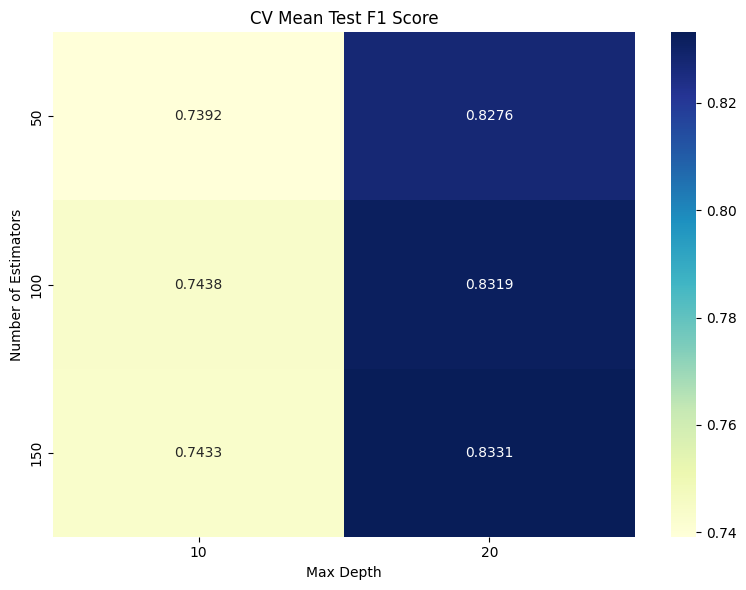

In [6]:
plt.figure(figsize=(8, 6))
heatmap_data = results.pivot_table(
    values='mean_test_score',
    index='param_rf__n_estimators',
    columns='param_rf__max_depth'
)
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("CV Mean Test F1 Score")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.tight_layout()
plt.show()

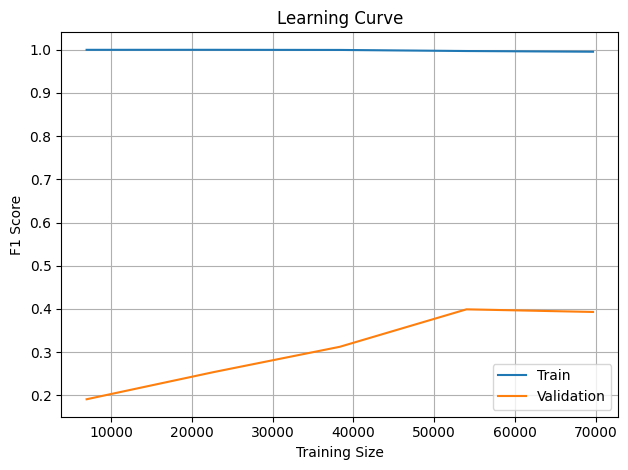

In [7]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X, y, cv=5, scoring='f1_macro', train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
